In [138]:
from __future__ import annotations

import operator
from pathlib import  Path
from typing import TypedDict,List,Optional,Literal,Annotated

from pydantic import BaseModel, Field

from langgraph.graph import StateGraph,START,END
from langgraph.types import Send

from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import SystemMessage,HumanMessage
from langchain_tavily import TavilySearch

In [139]:
from dotenv import load_dotenv
load_dotenv()

True

## Schemas

In [140]:
class Task(BaseModel):
    id: int
    title: str

    goal: str = Field(
        ...,
        description="One sentence describing what the reader should be able to do/understand after this section."
    )

    bullets: List[str] = Field(
        ...,
        min_length=3,
        max_length=6,
        description="2-3 concrete, non-overlapping subpoints to cover in this section.",
    )

    target_words : str = Field(...,description="Target word count for this section (30-50).")


    tags: List[str] = Field(default_factory=list)
    requires_research: bool = False
    requires_citations: bool = False
    requires_code: bool = False


In [141]:
class Plan(BaseModel):
    blog_title : str
    audience : str
    tone: str

    blog_kind: Literal["explainer", "tutorial", "news_roundup", "comparison", "system_design"] = "explainer"
    constraints: List[str] = Field(default_factory=list)
    tasks: List[Task]


In [142]:
class RouterDecision(BaseModel):
    needs_research: bool
    mode: Literal["closed_book", "hybrid", "open_book"]
    queries: List[str] = Field(default_factory=list)


In [143]:
class EvidenceItem(BaseModel):
    title: str
    url: str
    published_at: Optional[str] = None  # keep if Tavily provides; DO NOT rely on it
    snippet: Optional[str] = None
    source: Optional[str] = None

In [144]:
class EvidencePack(BaseModel):
    evidence: List[EvidenceItem] = Field(default_factory=list)

## State

In [145]:
class State(TypedDict):

    topic: str

    mode : str
    needs_research: bool
    queries: List[str]
    evidence: List[EvidenceItem]
    
    plan: Optional[Plan]

    sections : Annotated[List[tuple[int,str]],operator.add]
    final: str

## Define LLM

In [146]:
llm = ChatGoogleGenerativeAI(model='gemini-2.5-flash')

## Router Node

In [147]:
ROUTER_SYSTEM = """ 
You are a routing module for a technical blog planner.

Decide whether web research is needed BEFORE planning.

Modes:
- closed_book (needs_research=false):
  Evergreen topics where correctness does not depend on recent facts (concepts, fundamentals).
- hybrid (needs_research=true):
  Mostly evergreen but needs up-to-date examples/tools/models to be useful.
- open_book (needs_research=true):
  Mostly volatile: weekly roundups, "this week", "latest", rankings, pricing, policy/regulation.

If needs_research=true:
- Output 2-3 high-signal queries.
- Queries should be scoped and specific (avoid generic queries like just "AI" or "LLM").
- If user asked for "last week/this week/latest", reflect that constraint IN THE QUERIES.
"""

def router_node(state: State) -> dict :
    
    topic = state['topic']

    decider = llm.with_structured_output(RouterDecision)

    decision = decider.invoke([
        SystemMessage(content=ROUTER_SYSTEM),
        HumanMessage(content=f"Topic: {topic}"),
    ])

    return {
        "needs_research": decision.needs_research,
        "mode": decision.mode,
        "queries": decision.queries,
    }

In [148]:
def route_next(state: State) -> dict:

    return "research" if state['needs_research'] else "orchestrator"

## Research Node

In [149]:
def _tavily_search(query: str, max_results: int = 2) -> List[dict]:
    
    tool = TavilySearch(max_results=max_results)
    response = tool.invoke({"query": query})

    results = response.get("results", []) if isinstance(response, dict) else []

    normalized: List[dict] = []
    for r in results or []:

        if not isinstance(r, dict):
            continue
        
        normalized.append(
            {
                "title": r.get("title") or "",
                "url": r.get("url") or "",
                "snippet": r.get("content") or r.get("snippet") or "",
                "published_at": r.get("published_date") or r.get("published_at"),
                "source": r.get("source"),
            }
        )
    return normalized

RESEARCH_SYSTEM = """You are a research synthesizer for technical writing.

Given raw web search results, produce a deduplicated list of EvidenceItem objects.

Rules:
- Only include items with a non-empty url.
- Prefer relevant + authoritative sources (company blogs, docs, reputable outlets).
- If a published date is explicitly present in the result payload, keep it as YYYY-MM-DD.
  If missing or unclear, set published_at=null. Do NOT guess.
- Keep snippets short.
- Deduplicate by URL.
"""

def research_node(state: State) -> dict:

    queries = (state.get('queries',[]) or [])
    max_results = 2 # total search max_result * queries

    raw_results: List[dict] = []

    for q in queries:
        raw_results.extend(_tavily_search(q,max_results=max_results))

    if not raw_results:
        return {"evidence": []}
    
    extractor = llm.with_structured_output(EvidencePack)
    pack = extractor.invoke([
        SystemMessage(content=RESEARCH_SYSTEM),
        HumanMessage(content=f"Raw Results:\n{raw_results}"),
    ])


    dedup = {}

    for e in pack.evidence:
        if e.url:
            dedup[e.url] = e

    return {'evidence': list(dedup.values())}


## Orchestrator Node

In [150]:
ORCH_SYSTEM = """You are a senior technical writer and developer advocate.
Your job is to produce a highly actionable outline for a technical blog post.

Hard requirements:
- Create 2-3 sections (tasks) suitable for the topic and audience.
- Each task must include:
  1) goal (1 sentence)
  2) 2-3 bullets that are concrete, specific, and non-overlapping
  3) target word count (40-50)

Quality bar:
- Assume the reader is a developer; use correct terminology.
- Bullets must be actionable: build/compare/measure/verify/debug.
- Ensure the overall plan includes at least 2 of these somewhere:
  * minimal code sketch / MWE (set requires_code=True for that section)
  * edge cases / failure modes
  * performance/cost considerations
  * security/privacy considerations (if relevant)
  * debugging/observability tips

Grounding rules:
- Mode closed_book: keep it evergreen; do not depend on evidence.
- Mode hybrid:
  - Use evidence for up-to-date examples (models/tools/releases) in bullets.
  - Mark sections using fresh info as requires_research=True and requires_citations=True.
- Mode open_book:
  - Set blog_kind = "news_roundup".
  - Every section is about summarizing events + implications.
  - DO NOT include tutorial/how-to sections unless user explicitly asked for that.
  - If evidence is empty or insufficient, create a plan that transparently says "insufficient sources"
    and includes only what can be supported.

Output must strictly match the Plan schema.
"""

def orchestrator_node(state: State)->dict :

    planner = llm.with_structured_output(Plan)

    evidence = state.get('evidence',[])
    mode = state.get("mode","closed_book")

    plan = planner.invoke(
        [
            SystemMessage(content = ORCH_SYSTEM),
            HumanMessage(
                content = (
                    f"Topic: {state['topic']}\n"
                    f"Mode: {mode}\n\n"
                    f"Evidence (ONLY use for fresh claims; may be empty):\n"
                    f"{[e.model_dump() for e in evidence][:16]}"
                )
            )
        ]
    )

    return {'plan':plan}

### Fanout Node

In [151]:
def fanout(state: State):
    return [
        Send(
            "worker",
            {
                "task": task.model_dump(),
                "topic": state["topic"],
                "mode": state["mode"],
                "plan": state["plan"].model_dump(),
                "evidence": [e.model_dump() for e in state.get("evidence", [])],
            },
        )
        for task in state["plan"].tasks
    ]

## Worker Node

In [152]:
WORKER_SYSTEM = """You are a senior technical writer and developer advocate.
Write ONE section of a technical blog post in Markdown.

Hard constraints:
- Follow the provided Goal and cover ALL Bullets in order (do not skip or merge bullets).
- Stay close to Target words (±15%).
- Output ONLY the section content in Markdown (no blog title H1, no extra commentary).
- Start with a '## <Section Title>' heading.

Scope guard:
- If blog_kind == "news_roundup": do NOT turn this into a tutorial/how-to guide.
  Do NOT teach web scraping, RSS, automation, or "how to fetch news" unless bullets explicitly ask for it.
  Focus on summarizing events and implications.

Grounding policy:
- If mode == open_book:
  - Do NOT introduce any specific event/company/model/funding/policy claim unless it is supported by provided Evidence URLs.
  - For each event claim, attach a source as a Markdown link: ([Source](URL)).
  - Only use URLs provided in Evidence. If not supported, write: "Not found in provided sources."
- If requires_citations == true:
  - For outside-world claims, cite Evidence URLs the same way.
- Evergreen reasoning is OK without citations unless requires_citations is true.

Code:
- If requires_code == true, include at least one minimal, correct code snippet relevant to the bullets.

Style:
- Short paragraphs, bullets where helpful, code fences for code.
- Avoid fluff/marketing. Be precise and implementation-oriented.
"""


def worker_node(payload: dict) -> dict:

    task = Task(**payload["task"])
    plan = Plan(**payload['plan'])
    evidence = [EvidenceItem(**e) for e in payload.get("evidence",[])]
    topic = payload['topic']
    mode = payload.get("mode","closed_book")

    bullets_text = "\n -" + "\n -".join(task.bullets)

    evidence_text = ""
    if evidence:
        evidence_text = "\n".join(
            f"- {e.title} | {e.url} | {e.published_at or 'date:unknown'}".strip()
            for e in evidence[:20]
        )
    
    section_md = llm.invoke(
        [
            SystemMessage(content=WORKER_SYSTEM),
            HumanMessage(
                content=(
                    f"Blog title: {plan.blog_title}\n"
                    f"Audience: {plan.audience}\n"
                    f"Tone: {plan.tone}\n"
                    f"Blog kind: {plan.blog_kind}\n"
                    f"Constraints: {plan.constraints}\n"
                    f"Topic: {topic}\n"
                    f"Mode: {mode}\n\n"
                    f"Section title: {task.title}\n"
                    f"Goal: {task.goal}\n"
                    f"Target words: {task.target_words}\n"
                    f"Tags: {task.tags}\n"
                    f"requires_research: {task.requires_research}\n"
                    f"requires_citations: {task.requires_citations}\n"
                    f"requires_code: {task.requires_code}\n"
                    f"Bullets:{bullets_text}\n\n"
                    f"Evidence (ONLY use these URLs when citing):\n{evidence_text}\n"
                )
            ),
        ]
    ).content.strip()

    return {"sections": [(task.id,section_md)]}

### Reducer node


In [153]:
def reducer_node(state: State) -> dict:

    plan = state["plan"]

    ordered_sections = [md for _, md in sorted(state["sections"], key=lambda x: x[0])]
    body = "\n\n".join(ordered_sections).strip()
    final_md = f"# {plan.blog_title}\n\n{body}\n"

    filename = "".join(c if c.isalnum() or c in (" ", "_", "-") else "" for c in plan.blog_title)
    filename = filename.strip().lower().replace(" ", "_") + ".md"
    Path(filename).write_text(final_md, encoding="utf-8")

    return {"final": final_md}

# Graph Build

In [154]:
G = StateGraph(State)
G.add_node("router",router_node)
G.add_node("research",research_node)
G.add_node("orchestrator",orchestrator_node)
G.add_node("worker",worker_node)
G.add_node("reducer",reducer_node)

G.add_edge(START,'router')
G.add_conditional_edges("router",route_next,{"research":"research","orchestrator":'orchestrator'})
G.add_edge("research","orchestrator")

G.add_conditional_edges("orchestrator",fanout,['worker'])
G.add_edge("worker","reducer")
G.add_edge("reducer",END)

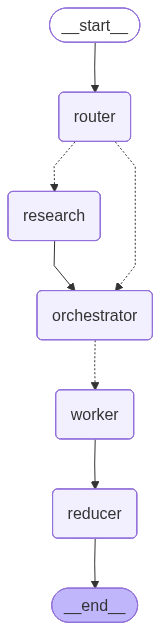

In [155]:
app = G.compile()
app

In [156]:
def run(topic: str):
    out = app.invoke(
        {
            "topic": topic,
            "mode": "",
            "needs_research": False,
            "queries": [],
            "evidence": [],
            "plan": None,
            "sections": [],
            "final": "",
        }
    )

    return out

In [157]:
run("State of Multimodal LLMS in 2026")

{'topic': 'State of Multimodal LLMS in 2026',
 'mode': 'open_book',
 'needs_research': True,
 'queries': ['Projected capabilities of multimodal LLMs by 2026',
  'Expected challenges and breakthroughs for multimodal AI 2026',
  'Industry expert predictions for multimodal LLM adoption and impact 2026'],
 'evidence': [EvidenceItem(title='Top 10 Large Language Models (LLMs) in 2026 - Kanerika', url='https://kanerika.com/blogs/top-llms/', published_at=None, snippet='Large Language Models (LLMs) are advanced AI systems designed to process and generate text that mimics human language. Fine-tuning involves training the model on domain-specific data, such as legal documents, customer service transcripts, or healthcare information. Multimodal Capabilities: If your application requires processing not just text but also images or audio, consider models that support multimodal inputs.', source=None),
  EvidenceItem(title='Top LLMs and AI Trends for 2026 | Clarifai Industry Guide', url='https://www.